In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import os
import pandas as pd
import glasbey

sc.logging.print_header()

/data/home/hmy961/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.23.5 scipy==1.10.0 pandas==2.2.2 scikit-learn==1.2.1 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.13


In [2]:
# Define input files 
sample_dir = '/data/WHRI-GenomeCentre/shares/Projects/NGS_Projects/NanostringCosMX/Projects/Noorani_Imran/GC-IN-10692/Data/formatted/tma2'
meta_file = [item for item in os.listdir(sample_dir) if 'metadata_file' in item][0]
counts_file = [item for item in os.listdir(sample_dir) if 'exprMat_file' in item][0]
fov_file = [item for item in os.listdir(sample_dir) if 'fov_positions_file' in item][0]

print(meta_file)
print(counts_file)
print(fov_file)

GCIN10692_TMA2_metadata_file.csv.gz
GCIN10692_TMA2_exprMat_file.csv.gz
GCIN10692_TMA2_fov_positions_file.csv.gz


In [3]:
# Load the fov file and check
fov_df = pd.read_csv(os.path.join(sample_dir, fov_file))

print(fov_df)

     FOV  x_global_px  y_global_px  x_global_mm  y_global_mm
0      1        10250       156675        1.230       18.801
1      2        14516       156675        1.742       18.801
2      3        18775       156675        2.253       18.801
3      4        23041       156675        2.765       18.801
4      5        10250       152408        1.230       18.289
..   ...          ...          ...          ...          ...
771  772        66891       160858        8.027       19.303
772  773        71441       160916        8.573       19.310
773  774        75708       160916        9.085       19.310
774  775       112258       129825       13.471       15.579
775  776         3241        10766        0.389        1.292

[776 rows x 5 columns]


In [4]:
# Reformat the FOV column - colname should be lowercase
if 'FOV' in fov_df.columns:
  print("Refactoring file to older format.")
  # Rename 'FOV' column to 'fov'
  fov_df.rename(columns={'FOV': 'fov'}, inplace=True)
  # have fov_file reference the new, formatted file and write it
  fov_file = os.path.join(sample_dir,'fov_positions_formatted.csv')
  fov_df.to_csv(fov_file, index=False)

print(fov_df)

Refactoring file to older format.
     fov  x_global_px  y_global_px  x_global_mm  y_global_mm
0      1        10250       156675        1.230       18.801
1      2        14516       156675        1.742       18.801
2      3        18775       156675        2.253       18.801
3      4        23041       156675        2.765       18.801
4      5        10250       152408        1.230       18.289
..   ...          ...          ...          ...          ...
771  772        66891       160858        8.027       19.303
772  773        71441       160916        8.573       19.310
773  774        75708       160916        9.085       19.310
774  775       112258       129825       13.471       15.579
775  776         3241        10766        0.389        1.292

[776 rows x 5 columns]


In [5]:
# Load data - why are some FOVs skipped?
adata2 = sq.read.nanostring(
    path=sample_dir,
    counts_file=counts_file,
    meta_file=meta_file,
    fov_file=fov_file
)

print(adata2)

AnnData object with n_obs × n_vars = 521946 × 1165
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'slide_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'CenterX_global_px', 'CenterY_global_px', 'cell', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_fov'


In [6]:
# Place control targets into separate variables
adata2.var["Negative"] = adata2.var_names.str.startswith("Negative")
adata2.var["SystemControl"] = adata2.var_names.str.startswith("SystemControl")
adata2

AnnData object with n_obs × n_vars = 521946 × 1165
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'slide_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'CenterX_global_px', 'CenterY_global_px', 'cell', 'cell_ID'
    var: 'Negative', 'SystemControl'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_fov'

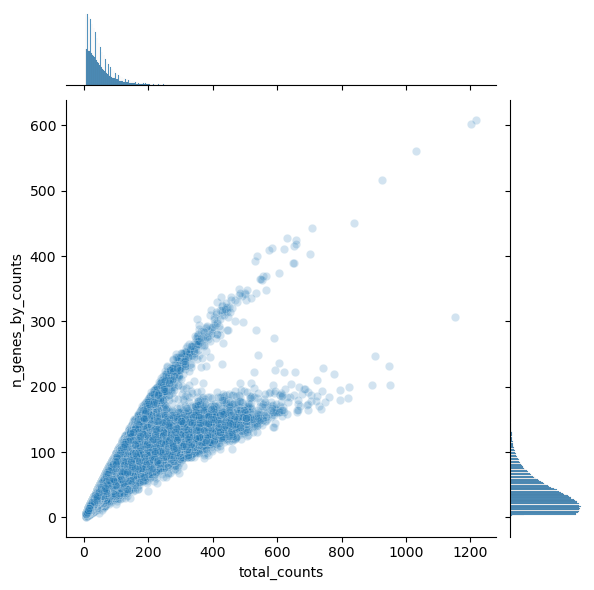

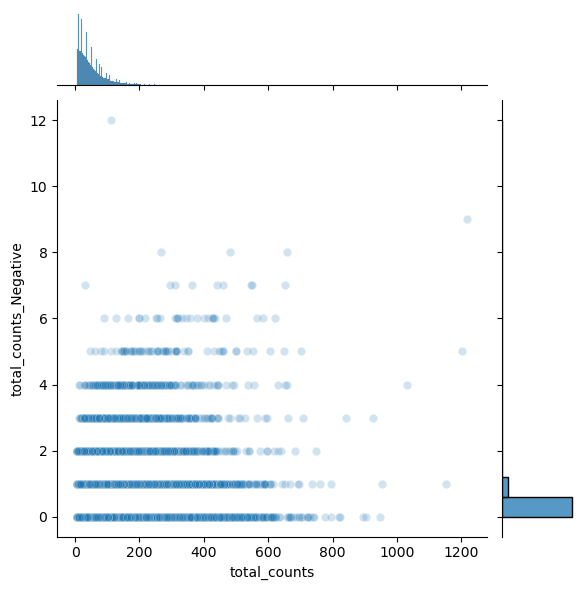

In [7]:
# QC plots
sc.pp.calculate_qc_metrics(adata2, qc_vars=["Negative", "SystemControl"], inplace=True)

# Unique genes per cell vs total counts per cell
sns.jointplot(
    data=adata2.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="scatter",
    alpha=0.2
)
#plt.savefig("figures/fig-qc.png", dpi=200)

# Total negative probe counts per cell vs total counts per cell
sns.jointplot(
    data=adata2.obs,
    x="total_counts",
    y="total_counts_Negative",
    kind="scatter",
    alpha=0.2
)
#plt.savefig("figures/fig-qc1.png", dpi=200)


In [8]:
# Proportion of negative counts 
adata2.obs["total_counts_Negative"].sum() / adata2.obs["total_counts"].sum() * 100

0.2063050050864477

/tmp/3794900.1.all.q/ipykernel_22493/3310129254.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata2.obs.groupby("fov").sum()["total_counts"],


<Axes: title={'center': 'Transcripts per FOV'}, xlabel='total_counts', ylabel='Count'>

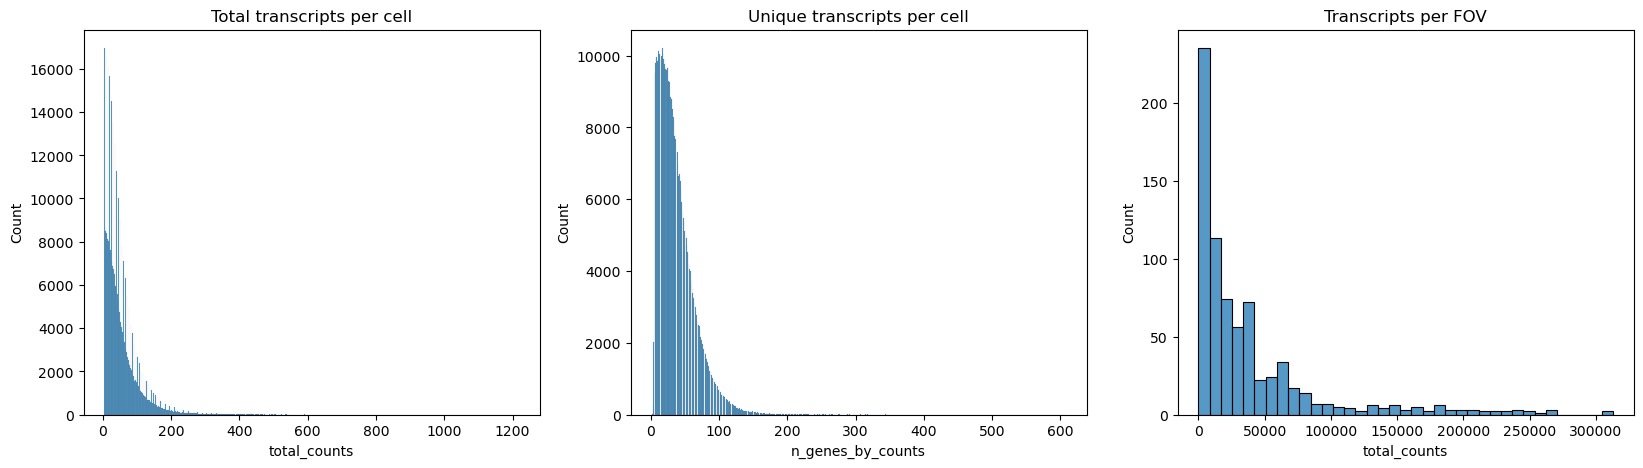

In [9]:
# More QC plots 
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata2.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata2.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("Transcripts per FOV")
sns.histplot(
    adata2.obs.groupby("fov").sum()["total_counts"],
    kde=False,
    ax=axs[2],
)

<Axes: title={'center': 'CD68'}, xlabel='Mean.CD68', ylabel='Count'>

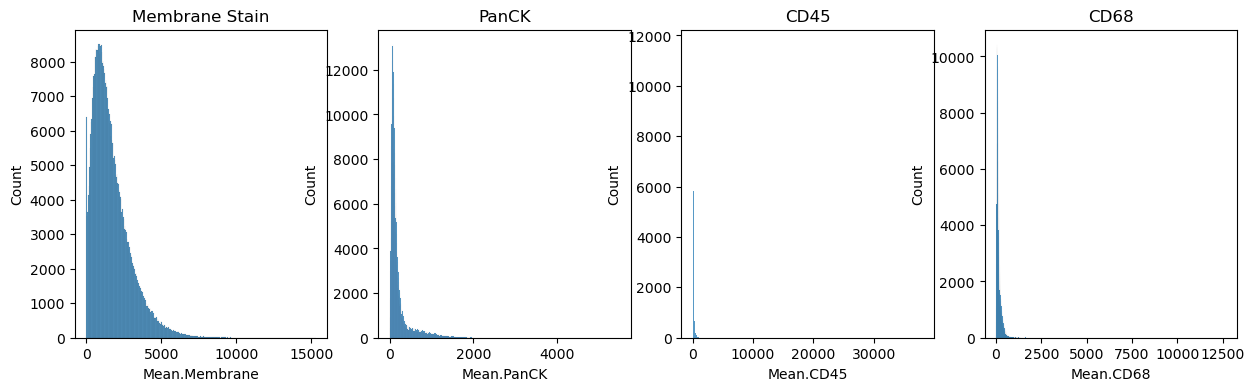

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Membrane Stain")
sns.histplot(
    adata2.obs["Mean.Membrane"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("PanCK")
sns.histplot(
    adata2.obs["Mean.PanCK"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("CD45")
sns.histplot(
    adata2.obs["Mean.CD45"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("CD68")
sns.histplot(
    adata2.obs["Mean.CD68"],
    kde=False,
    ax=axs[3],
)

In [11]:
# Filter 
adata2.shape

(521946, 1165)

In [19]:
# Filter
sc.pp.filter_cells(adata2, min_counts=50) # Suggested = 250
sc.pp.filter_genes(adata2, min_cells=100) # Suggested = 1000

In [20]:
adata2.shape

(93316, 1104)

In [21]:
adata2.layers["counts"] = adata2.X.copy()

In [22]:
sc.pp.normalize_total(adata2, inplace=True, exclude_highly_expressed=True)
sc.pp.log1p(adata2)

In [23]:
sc.pp.pca(adata2, n_comps=50)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2, min_dist=0.2, spread=1)
sc.tl.leiden(adata2)

In [27]:
# Take a look at number of clusters 
adata2.obs['leiden']

12_2       1
17_2       2
20_2       2
23_2       2
26_2       2
          ..
292_776    3
300_776    3
306_776    3
313_776    6
316_776    1
Name: leiden, Length: 93316, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

In [43]:
# Make a list of cluster IDs
clusters = list(range(11))
clusters = map(str, clusters)
print(clusters)

# Create a categorical palette with 11 colours
custPal = glasbey.create_palette(palette_size=11)
print(custPal)

# Make a tuple of the two lists above to convert into dict
custPalDict = dict(zip(clusters, custPal))
print(custPalDict)

['#d21820', '#1869ff', '#008a00', '#f36dff', '#710079', '#aafb00', '#00bec2', '#ffa235', '#5d3d04', '#08008a', '#005d5d']
{'0': '#d21820', '1': '#1869ff', '2': '#008a00', '3': '#f36dff', '4': '#710079', '5': '#aafb00', '6': '#00bec2', '7': '#ffa235', '8': '#5d3d04', '9': '#08008a', '10': '#005d5d'}


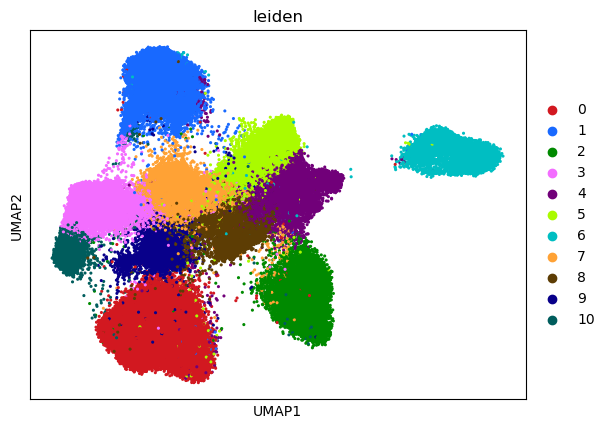

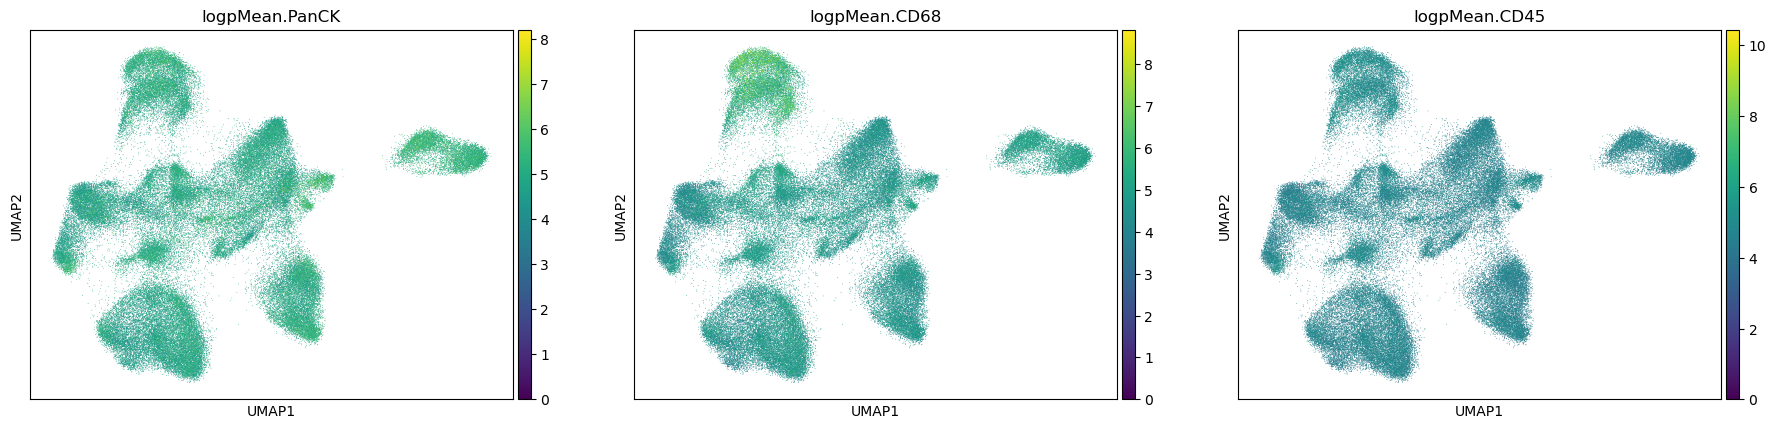

In [45]:
adata2.obs["logpMean.PanCK"] = np.log1p(adata2.obs['Mean.PanCK'])
adata2.obs["logpMean.CD45"] = np.log1p(adata2.obs['Mean.CD45'])
adata2.obs["logpMean.CD68"] = np.log1p(adata2.obs['Mean.CD68'])

sc.pl.umap(
    adata2,
    color="leiden",
    s=20,
    palette=custPalDict,
)

sc.pl.umap(
    adata2,
    color=["logpMean.PanCK", "logpMean.CD68", "logpMean.CD45"]
)

In [49]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata2, groupby="leiden", method="wilcoxon")

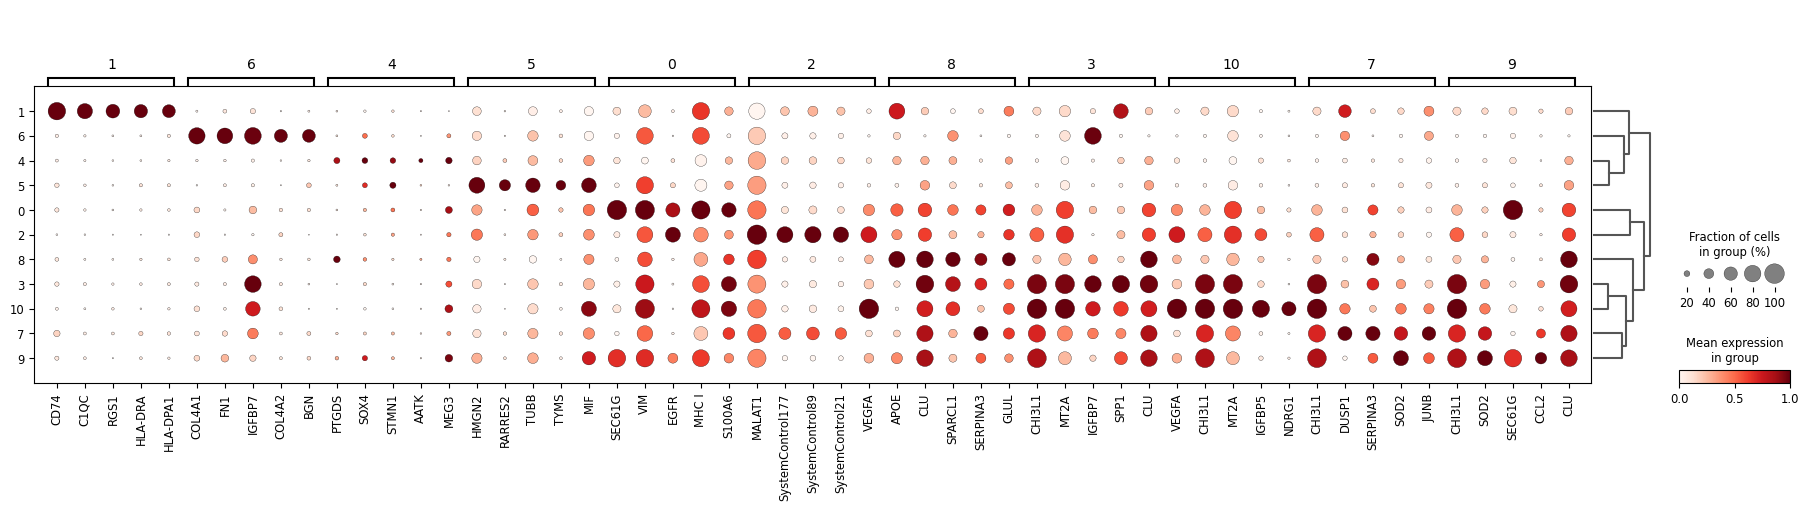

In [51]:
# Plot cluster genes 
sc.pl.rank_genes_groups_dotplot(
    adata2, groupby="leiden", standard_scale="var", n_genes=5
)

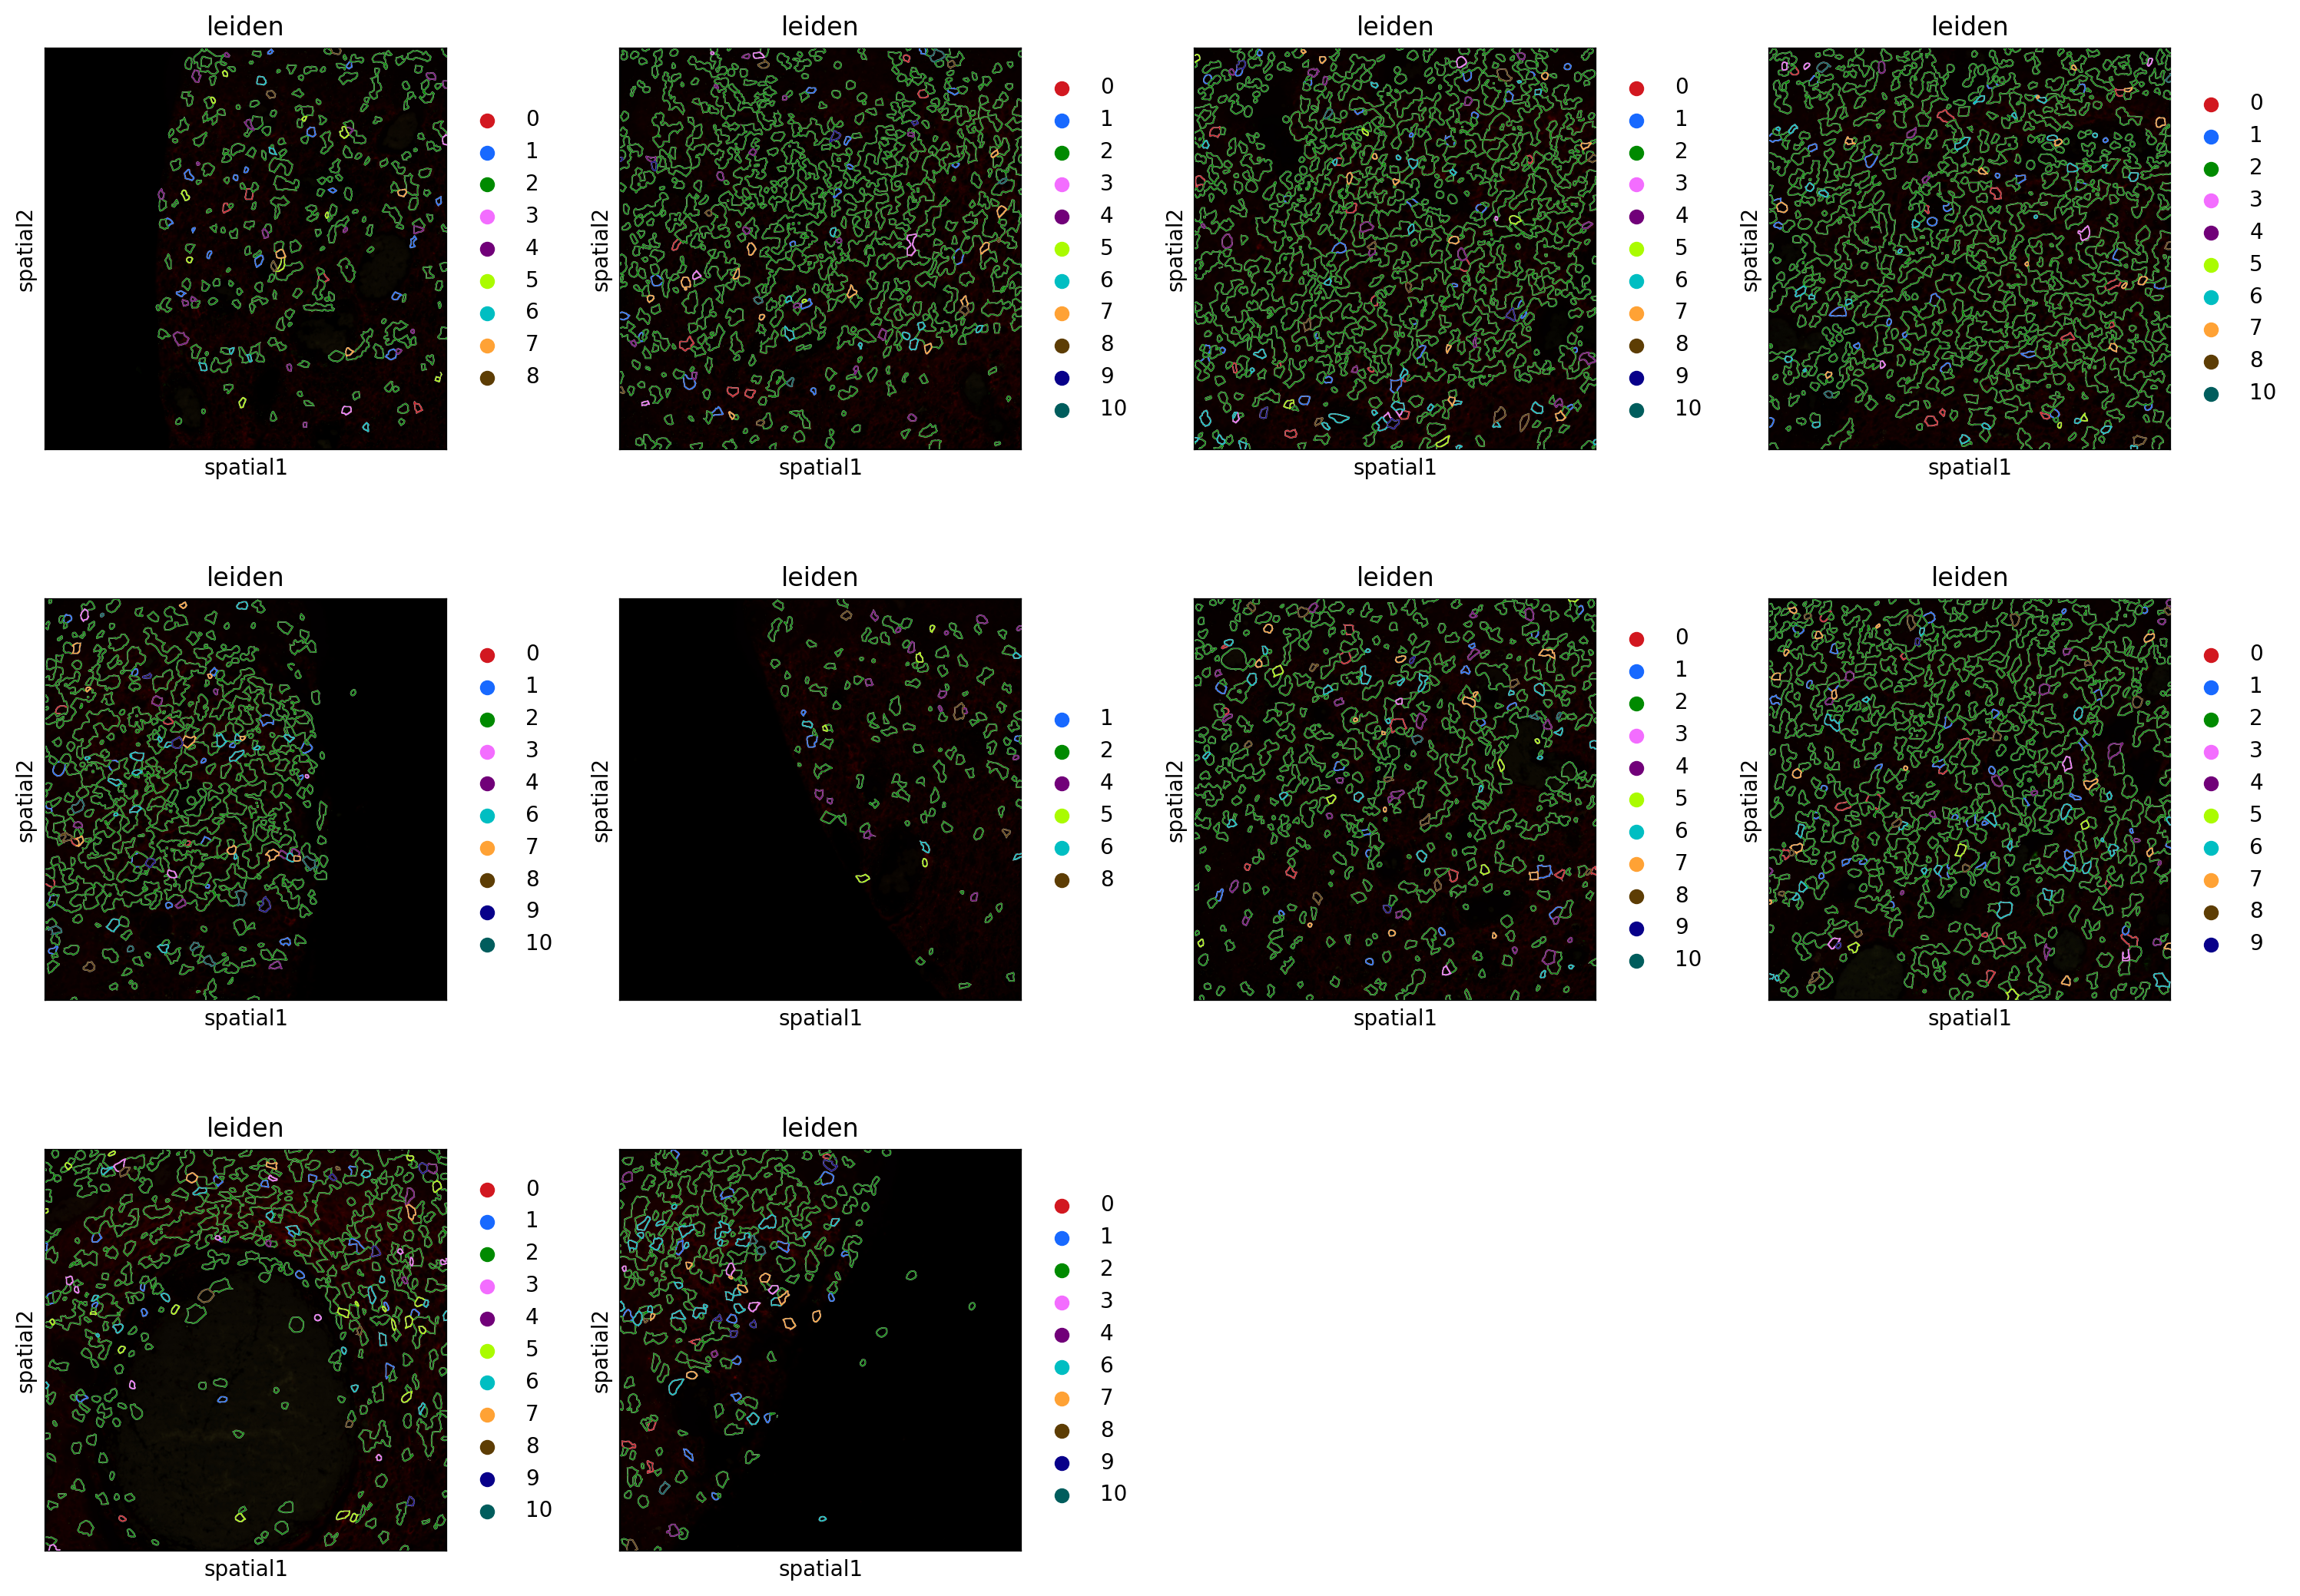

In [52]:
# Plot FOV of interest segmentation
sq.pl.spatial_segment(
    adata2,
    color="leiden",
    seg_contourpx=20,
    seg_cell_id="cell_ID",
    library_key="fov",
    library_id=["10","11","12","13","14","15","16","17","18","19"],
    img=True,
    size=60,
    figsize = (4, 4),
    dpi = 200
)

In [ ]:
# Subset down to FOV17 
adata_subset = adata2[adata2.obs.fov == "17"].copy()

sq.gr.spatial_neighbors(adata_subset, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_subset,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_subset.uns["moranI"].head(10)

In [ ]:
# Plot spatially correlated genes 
sq.pl.spatial_segment(
    adata_subset,
    library_id="17",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["VEGFA", "RGS5", "FN1"],
    size=60,
    img=False,
    figsize=(4, 4),
    dpi = 200
)

In [ ]:
# Spatial co-occurence
sq.gr.co_occurrence(
    adata_subset,
    cluster_key="leiden",
)

sq.pl.co_occurrence(
    adata_subset,
    cluster_key="leiden",
    clusters="1"
)
sq.pl.spatial_segment(
    adata_subset,
    shape="hex",
    color="leiden",
    library_id="17",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60
)